1. Where are the old left-handed people?

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
data_url_1="https://gist.githubusercontent.com/mbonsma/8da0990b71ba9a09f7de395574e54df1/raw/aec88b30af87fad8d45da7e774223f91dad09e88/lh_data.csv"
lefthanded_data = pd.read_csv(data_url_1)
print(lefthanded_data.head())

   Age       Male     Female
0   10  12.717558  12.198041
1   11  15.318830  11.144804
2   12  14.808281  11.549240
3   13  13.793744  11.276442
4   14  15.156304  11.572906


Text(0, 0.5, 'Age')

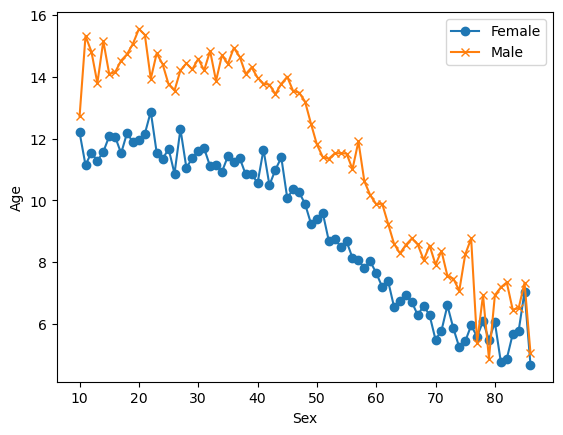

In [8]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot('Age', 'Female', data=lefthanded_data, marker = 'o')
ax.plot('Age', 'Male', data=lefthanded_data, marker='x')
ax.legend()
ax.set_xlabel('Sex')
ax.set_ylabel('Age')

2. Rates of left-handedness over time


Text(0, 0.5, 'Birth_year')

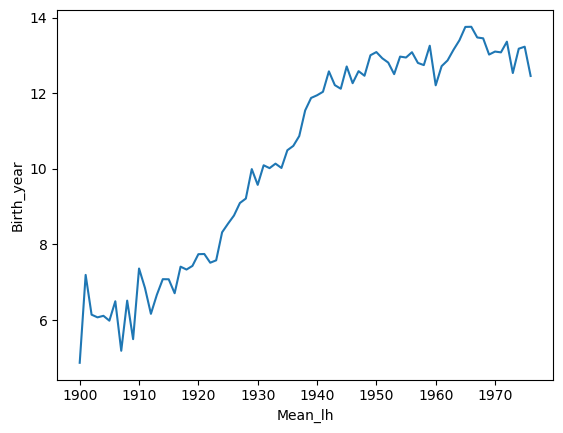

In [11]:
lefthanded_data["Birth_year"] = 1986 - lefthanded_data["Age"]

lefthanded_data["Mean_lh"] = lefthanded_data[["Female","Male"]].mean(axis=1)

fig, ax = plt.subplots()
ax.plot("Birth_year", "Mean_lh", data=lefthanded_data)
ax.set_xlabel("Mean_lh")
ax.set_ylabel("Birth_year")

3. Applying Bayes' rule

In [17]:
import numpy as np

def P_lh_given_A(ages_of_death, study_year = 1990):
    """ P(Left-handed | ages of death), calculated based on the reported rates of left-handedness.
    Inputs: numpy array of ages of death, study_year
    Returns: probability of left-handedness given that subjects died in `study_year` at ages `ages_of_death` """
    early_1990s_rate = lefthanded_data['Mean_lh'][-10:].mean()
    late_1990s_rate = lefthanded_data['Mean_lh'][:10].mean()
    middle_rates= lefthanded_data.loc[lefthanded_data['Birth_year'].isin(study_year - ages_of_death)]['Mean_lh']
    youngest_age = study_year - 1986 +10
    oldest_age = study_year - 1986 +86

    P_return = np.zeros(ages_of_death.shape)
    P_return[ages_of_death> oldest_age] = early_1990s_rate/100
    P_return[ages_of_death< youngest_age] = late_1990s_rate/100
    P_return[np.logical_and((ages_of_death <= oldest_age), (ages_of_death >= youngest_age))] = middle_rates/100
    return P_return

4. When do people normally die?

Text(0, 0.5, 'Both Sexes')

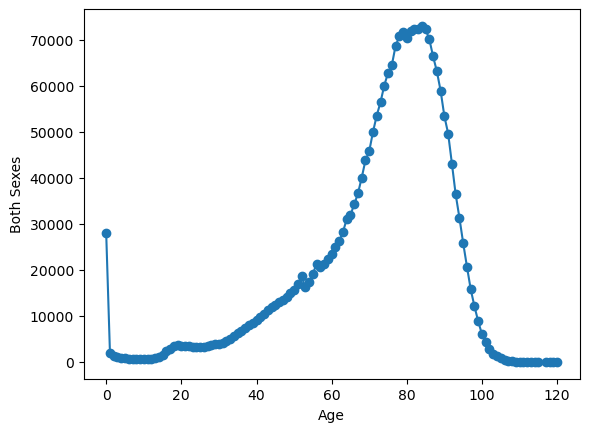

In [19]:
# Death distribution data for the United States in 1999
data_url_2= "https://gist.githubusercontent.com/mbonsma/2f4076aab6820ca1807f4e29f75f18ec/raw/62f3ec07514c7e31f5979beeca86f19991540796/cdc_vs00199_table310.tsv"

death_distribution_data = pd.read_csv(data_url_2, sep= '\t', skiprows=[1])

death_distribution_data = death_distribution_data.dropna(subset=["Both Sexes"])

fig , ax = plt.subplots()
ax.plot('Age', 'Both Sexes', data = death_distribution_data, marker='o')
ax.set_xlabel('Age')
ax.set_ylabel('Both Sexes')

5. The overall probability of left-handedness


In [21]:
def P_lh(death_distribution_data, study_year = 1990): # sum over P_lh for each age group
    """ Overall probability of being left-handed if you died in the study year
    Input: dataframe of death distribution data, study year
    Output: P(LH), a single floating point number """
    p_list = death_distribution_data['Both Sexes']*P_lh_given_A(death_distribution_data['Age'], study_year)

    p = np.sum(p_list)
    return p/np.sum(death_distribution_data['Both Sexes'])

print(P_lh(death_distribution_data))

0.07766387615350638


6. Putting it all together: dying while left-handed (i)

In [22]:
def P_A_given_lh(ages_of_death, death_distribution_data, study_year = 1990):
    """ The overall probability of being a particular `age_of_death` given that you're left-handed """
    P_A = death_distribution_data["Both Sexes"][ages_of_death]/np.sum(death_distribution_data["Both Sexes"])
    P_left = P_lh(death_distribution_data, study_year) # use P_lh function to get probability of left-handedness overall
    P_lh_A = P_lh_given_A(ages_of_death, study_year) # use P_lh_given_A to get probability of left-handedness for a certain age
    return P_lh_A*P_A/P_left

7. Putting it all together: dying while left-handed (ii)

In [25]:
def P_A_given_rh(ages_of_death, death_distribution_data, study_year = 1990):
    """ The overall probability of being a particular `age_of_death` given that you're right-handed """
    P_A = death_distribution_data["Both Sexes"][ages_of_death]/np.sum(death_distribution_data["Both Sexes"])
    P_right = 1 - P_lh(death_distribution_data, study_year)# either you're left-handed or right-handed, so P_right = 1 - P_left
    P_rh_A = 1 - P_lh_given_A(ages_of_death, study_year) # P_rh_A = 1 - P_lh_A 
    return P_rh_A*P_A/P_right

8. Plotting the distributions of conditional probabilities

Text(0, 0.5, 'Probability of being age A at death')

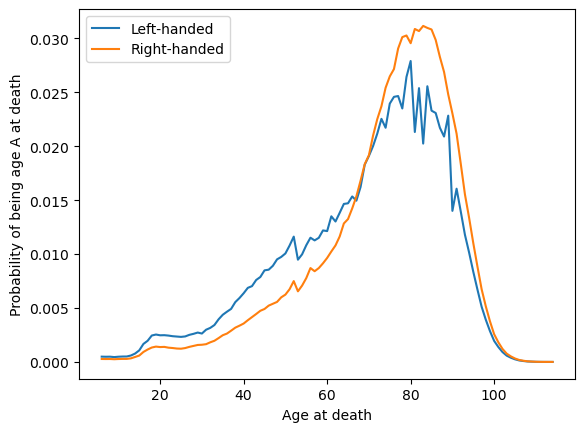

In [27]:
ages = np.arange(6, 115, 1) 

left_handed_probability = P_A_given_lh(ages, death_distribution_data)
right_handed_probability = P_A_given_rh(ages, death_distribution_data)

fig, ax = plt.subplots() 
ax.plot(ages, left_handed_probability, label = "Left-handed")
ax.plot(ages, right_handed_probability, label = "Right-handed")
ax.legend()
ax.set_xlabel("Age at death")
ax.set_ylabel("Probability of being age A at death")

9. Moment of truth: age of left and right-handers at death

In [29]:
# calculate average ages for left-handed and right-handed groups
# use np.array so that two arrays can be multiplied
average_lh_age =  np.nansum(ages*np.array(left_handed_probability))
average_rh_age =  np.nansum(ages*np.array(right_handed_probability))

# print the average ages for each group
print("Average age of lefthanded" + str(average_lh_age))
print("Average age of righthanded" + str(average_rh_age))

# print the difference between the average ages
print("The difference in average ages is " + str(round(average_lh_age - average_rh_age, 1)) + " years.")

Average age of lefthanded67.24503662801027
Average age of righthanded72.79171936526477
The difference in average ages is -5.5 years.


10. Final comments

In [30]:
# Calculate the probability of being left- or right-handed for all ages
left_handed_probability_2018 = P_A_given_lh(ages, death_distribution_data, study_year = 2018)
right_handed_probability_2018 = P_A_given_rh(ages, death_distribution_data, study_year = 2018)

# calculate average ages for left-handed and right-handed groups
average_lh_age_2018 = np.nansum(ages*np.array(left_handed_probability_2018))
average_rh_age_2018 = np.nansum(ages*np.array(right_handed_probability_2018))

print("The difference in average ages is " + 
      str(round(average_rh_age_2018 - average_lh_age_2018, 1)) + " years.")

The difference in average ages is 2.3 years.
